Александр Журавлев DST-120  
[ссылка](https://github.com/drSever/drSever_data_science/tree/main/Small_training_projects/project_4) на GitHub проекта.
***

## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти [здесь](https://lms.skillfactory.ru/assets/courseware/v1/c5e135f1dc26e5f342916b8ab78357f1/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_data_tourist.zip).

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd

# средства визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# статистические тесты
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, normaltest, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Наша таблица представлена следующими полями:  
  
**user_id** - идентификатор пользователя, зашедшего на сайт  
**date** - дата захода  
**group** - группа теста (контрольная — А или тестовая — B)  
**purchase** - признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)  
**price** - цена купленного тура (если покупка не состоялась, цена равна 0)

***
## <center> **Решение**

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [4]:
data.shape

(294478, 5)

**Выводы:**
- **data** - это таблица с **первоначальными данными**.
- Первоначальная таблица с данными **data** имеет 294478 строк, 5 столбцов, пустых значений нет.  
- Столбец **date** имеет тип данных **object**, что говорит о том, что придется приводить его к типу данных **datetime**.
***

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
# приводим столбец date к типу данных datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# сгруппируем данные по признаку группы
data_a = data[data['group'] == 'A'] # данные группы А
data_b = data[data['group'] == 'B'] # данные группы В

# расчитываем и выводим информацию о длительности тестирования в группах
print('Первая дата наблюдений группы А {}'.format(data_a['date'].min()))
print('Последняя дата наблюдений группы А {}'.format(data_a['date'].max()), '\n')
print('Первая дата наблюдений группы B {}'.format(data_a['date'].min()))
print('Последняя дата наблюдений группы B {}'.format(data_a['date'].max()))

Первая дата наблюдений группы А 2021-01-02 00:00:00
Последняя дата наблюдений группы А 2021-01-24 00:00:00 

Первая дата наблюдений группы B 2021-01-02 00:00:00
Последняя дата наблюдений группы B 2021-01-24 00:00:00


**Выводы:**  
- А/В тест выполнялся в промежуток с 2 января 2021 года по 24 января 2021 года.   
- Длительность тестирования одинакова в обеих группах.
- **data_a** и **data_b** - это **первоначальные** данные, разделенные по признаку группы.
***

## **Задание 7.3.**  

- Чему равно количество посещений сайта в группах А и B?  

- Чему равно суммарное количество покупок в группах А и B?  

- Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб. 

In [6]:
# сгруппируем первоначальные данные по группам A и B и 
# расчитаем кол-во посещений сайта и кол-во покупок, сумму покупок
data_info = data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).rename(columns={ # переименуем полученные столбы (признаки)
    'user_id': 'users_count', # данные по кол-ву посещений сайта
    'purchase':'purchase_sum', # данные о суммарном кол-ве покупок
    'price':'price_sum' # данные о сумме покупок
})

# выводим сгруппированные первоначальные данные
display(data_info)

# выводим данные о посещении сайта в группах А и В взяв данные из сгруппированной таблицы
print('В группе А {} посещений.'.format(data_info.loc['A', 'users_count']))
print('В группе B {} посещений.'.format(data_info.loc['B', 'users_count']))

# здесь мы возьмем первоначальные данные, разделенные по признаку группы

# расчитаем и выведем суммарное количество покупок в группах
purchase_sum_a = data_a['purchase'].sum()
purchase_sum_b = data_b['purchase'].sum()
print('Суммарное количество покупок в группе А {}'.format(purchase_sum_a))
print('Суммарное количество покупок в группе В {}'.format(purchase_sum_b))

# рассчитываем и выводим сумму покупок
price_sum_a = round((data_a['price'].sum()/1e6),2)
price_sum_b = round((data_b['price'].sum()/1e6),2)
price_sum_ab = round((price_sum_a + price_sum_b),2)
print('Сумма покупок в группе А {} млн. рублей'.format(price_sum_a))
print('Сумма покупок в группе В {} млн. рублей'.format(price_sum_b))
print('Сумма всех покупок в обеих группах {} млн. рублей'.format(price_sum_ab))


,users_count,purchase_sum,price_sum
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


В группе А 147202 посещений.
В группе B 147276 посещений.
Суммарное количество покупок в группе А 17723
Суммарное количество покупок в группе В 17514
Сумма покупок в группе А 1436.26 млн. рублей
Сумма покупок в группе В 1554.1 млн. рублей
Сумма всех покупок в обеих группах 2990.36 млн. рублей


**Выводы:**
- **data_info** - это сгруппированные **первоначальные данные** в разрезе признака группы.  
- ответы на вопросы задания представлены в ячейке вывода.
***

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?  
  
**Подсказка:**  

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [7]:
# зададим множества, содержащие пользователей групп А и В, используя
# data_a и data_b содержащие первоначальные данные групп А и В соответственно
user_id_a = set(data_a['user_id']) # пользователи группы А
user_id_b = set(data_b['user_id']) # пользователи группы В

# объединим множества, получив пользователей в обеих группах
user_id_ab = user_id_a.intersection(user_id_b)

# выведем количество пользователей в обеих группах
print('В процессе А/В-тестирования {} пользователей попали в обе группы.'.format(len(user_id_ab)))

В процессе А/В-тестирования 1895 пользователей попали в обе группы.


**Вывод:** в обеих группах присутствуют 1895 пользователей которых следует удалить.
***

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.  

Возможный вариант исключения пользователей:

In [8]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_id_ab)]

Где user_id_ab - множество пересечений пользователей групп А и B.

**Вывод:** обновленные (очищеные от участников в обеих группах) **первоначальные данные** содержатся в таблице **updated_data**.
***

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

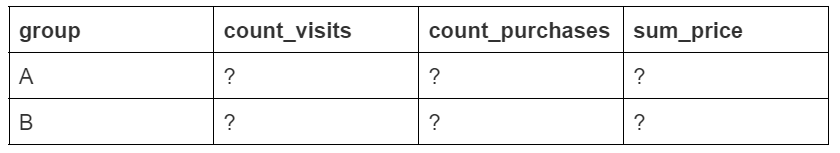
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [9]:
# заново сгруппируем данные по признаку группы
# чтобы получить заданную таблицу сбросим индексы и переименуем столбцы
data_info = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={ # сбросим индексы и переименуем столбцы
    'user_id': 'count_visits', # данные по кол-ву посещений сайта (кол-во пользователей)
    'purchase':'count_purchases', # данные о суммарном кол-ве покупок
    'price':'sum_price' # данные о сумме покупок
})

# выведем полученную таблицу
display(data_info)

# расчитываем и выводим обновленные данные о посещении сайта в группах А и В
print('В группе А {} посещений.'.format(data_info[data_info['group'] == 'A']['count_visits'].iloc[0]))
print('В группе B {} посещений.'.format(data_info[data_info['group'] == 'B']['count_visits'].iloc[0]))

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


В группе А 145307 посещений.
В группе B 145381 посещений.


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

**Выводы:**  
- Количество посещений после очистки первоначальных данных уменьшилось почти на 2 000 в обеих группах.  
- В группе А посещений меньше, чем в группе В на 74 человека, как и в первоначальных данных.  
- Схожие изменения наблюдаются в оставшихся 2-х признаках.  
- Учитывая большое количество посещений в обеих группах, которые сопоставимы между собой (разница составляет 0.05%), полагаю, что можно говорить о сбалансированности выборок.  
***

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).  
  
- Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %  
- Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.  

In [10]:
# добавляем признак конверсии покупки
data_info['conversion'] = data_info['count_purchases'] / data_info['count_visits'] * 100 # конверсия покупки в %
# добавляем признак среднего чека
data_info['mean_check'] = data_info['sum_price'] / data_info['count_purchases'] # средний чек

# рассчитываем и выводим искомые данные
display(data_info)
print('Конверсия в группах А и В соответственно (%): ', 
      round((data_info['conversion'].iloc[0]),2), 'и',  
      round((data_info['conversion'].iloc[1]),2)
)
print('Средний чек в группах А и В соответсвенно (руб): ', 
      round(data_info['mean_check'].iloc[0]), 'и', 
      round(data_info['mean_check'].iloc[1])
)

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Конверсия в группах А и В соответственно (%):  12.03 и 11.89
Средний чек в группах А и В соответсвенно (руб):  81076 и 88665


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

**Выводы:**  
- По конверсии покупки вариант А более эффективен.  
- По среднему чеку наоборот - более эффективен вариант В.  

**Примечание:** данные выводы носят промежуточный характер.
***

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [11]:
# создадим сводную таблицу согласно условиям задания
data_info_pivot = pd.pivot_table(updated_data,
    index = ['group'],
    columns = ['price'],
    values = 'purchase',
    aggfunc = 'sum'
)

# рассчитываем и выводим искомые данные
display(data_info_pivot)
print('Количество проданных туров за 60 000 рублей в группах: ', data_info_pivot[60000], sep='\n')


price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Количество проданных туров за 60 000 рублей в группах: 
group
A    5271
B    1730
Name: 60000, dtype: int64


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

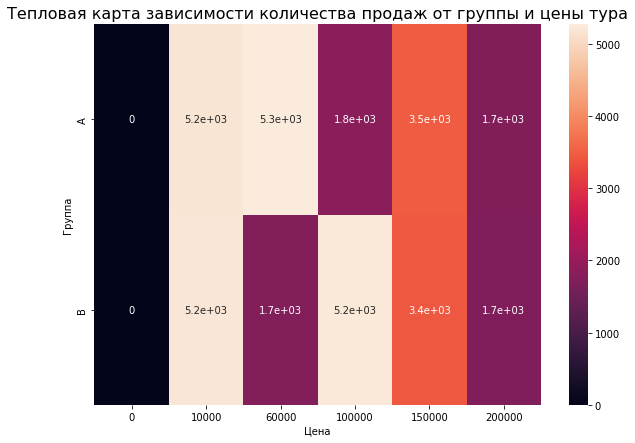

In [12]:
# зададим размер тепловой карты
fig = plt.figure(figsize=(10, 7))
# зададим параметры тепловой карты
heatmap = sns.heatmap(data=data_info_pivot, annot=True)
# подпишем тепловую карту
heatmap.set_title('Тепловая карта зависимости количества продаж от группы и цены тура', fontsize=16);
heatmap.set_xlabel('Цена');
heatmap.set_ylabel('Группа');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

**Выводы:**  
- Количество проданных туров за 60 000 рублей в группах А и В составляет 5271 и 1730 соответственно.  
- По турам стоимостью 60 000 рублей покупательская способность группы А значительно выше, по турам стоимостью 100 000 рублей - наоборот, в группе В их покупают значительно чаще.  
- По остальным турам большой разницы в покупательской способности между группами нет.  
***

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [13]:
# заново сгруппируем данные согласно условиям задания - по группам и датам
# прокачаем навыки работы с DataFrame и не будем сбрасывать индексы
data_info = updated_data.groupby(['group','date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).rename(columns={ # не будем в этот раз сбрасывать индексы
    'user_id': 'count_visits', # данные по кол-ву посещений сайта (кол-во пользователей)
    'purchase':'count_purchases', # данные о суммарном кол-ве покупок
    'price':'sum_price' # данные о сумме покупок
})

# добавляем необходимые столбцы в сгруппированную таблицу
# ежедневная конверсия в %
data_info['conversion'] = data_info['count_purchases'] / data_info['count_visits'] * 100
# ежедневный средний чек
data_info['mean_check'] = data_info['sum_price'] / data_info['count_purchases']

# рассчитаем и выведем необходимую информацию на дату 3 января 2021
print('Данные на 3 января 2021 года:')
print('\t- конверсия в группе А составила {}%'.format(round(data_info.loc['A', '2021-01-03'][3], 2)))
print('\t- конверсия в группе B составила {}%'.format(round(data_info.loc['B', '2021-01-03'][3], 2)))
print('\t- средний чек в группе А составил {} рублей'.format(round(data_info.loc['A', '2021-01-03'][4])))
print('\t- средний чек в группе B составил {} рублей'.format(round(data_info.loc['B', '2021-01-03'][4])))

Данные на 3 января 2021 года:
	- конверсия в группе А составила 11.34%
	- конверсия в группе B составила 11.39%
	- средний чек в группе А составил 82888 рублей
	- средний чек в группе B составил 87480 рублей


**Вывод:** ответы на вопросы в задании приведены в ячейке вывода.
***

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [14]:
# а теперь сбросим индексы для упрощения кода
data_info = data_info.reset_index()

# подготовим маски для разделения данных по группам
mask_a = data_info['group'] == 'A'
mask_b = data_info['group'] == 'B'

# добавляем кумулятивные признаки в группу А
data_info.loc[mask_a, 'cum_count_visits'] = data_info[mask_a]['count_visits'].cumsum()
data_info.loc[mask_a, 'cum_count_purchases'] = data_info[mask_a]['count_purchases'].cumsum()
data_info.loc[mask_a, 'cum_sum_price'] = data_info[mask_a]['sum_price'].cumsum()

# добавляем кумулятивные признаки в группу B
data_info.loc[mask_b, 'cum_count_visits'] = data_info[mask_b]['count_visits'].cumsum()
data_info.loc[mask_b, 'cum_count_purchases'] = data_info[mask_b]['count_purchases'].cumsum()
data_info.loc[mask_b, 'cum_sum_price'] = data_info[mask_b]['sum_price'].cumsum()

# вычислим кумулятивную конверсию и кумулятивный средний чек
data_info['cum_conversion'] = data_info['cum_count_purchases'] / data_info['cum_count_visits'] * 100
data_info['cum_mean_check'] = data_info['cum_sum_price'] / data_info['cum_count_purchases']

# вычисляем и выводим запрашиваемые данные

# кумулятивная конверсия в группе B на 20 января 2021 года
result_1 = data_info[(data_info['group'] == 'B') & (data_info['date'] == '2021-01-20')]['cum_conversion'].iloc[0]
# кумулятивный средний чек в группе А на 12 января 2021 года
result_2 = data_info[(data_info['group'] == 'A') & (data_info['date'] == '2021-01-12')]['cum_mean_check'].iloc[0]

# выводим запрашиваемые данные
print('Кумулятивная конверсия в группе B на 20 января 2021 года составила {}%'.format(round(result_1,2)))
print('Кумулятивный средний чек в группе А на 12 января 2021 года составил {} рублей'.format(round(result_2)))

Кумулятивная конверсия в группе B на 20 января 2021 года составила 11.9%
Кумулятивный средний чек в группе А на 12 января 2021 года составил 81492 рублей


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

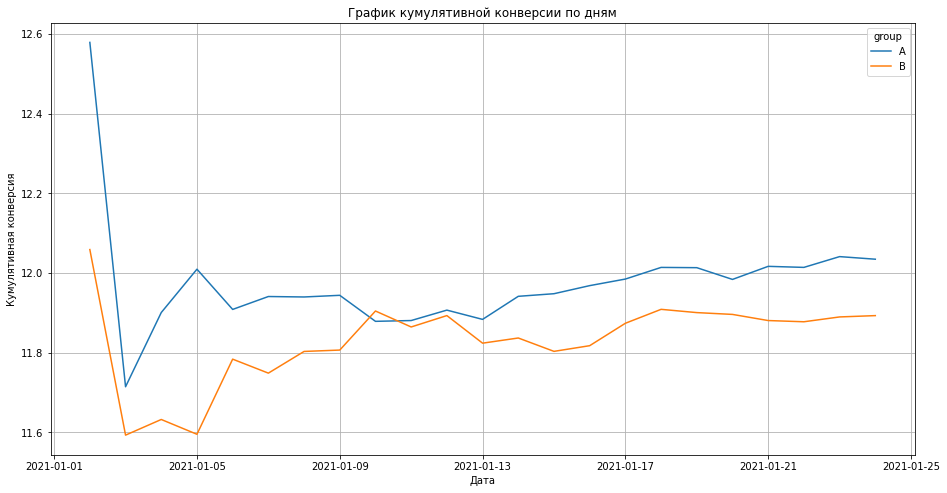

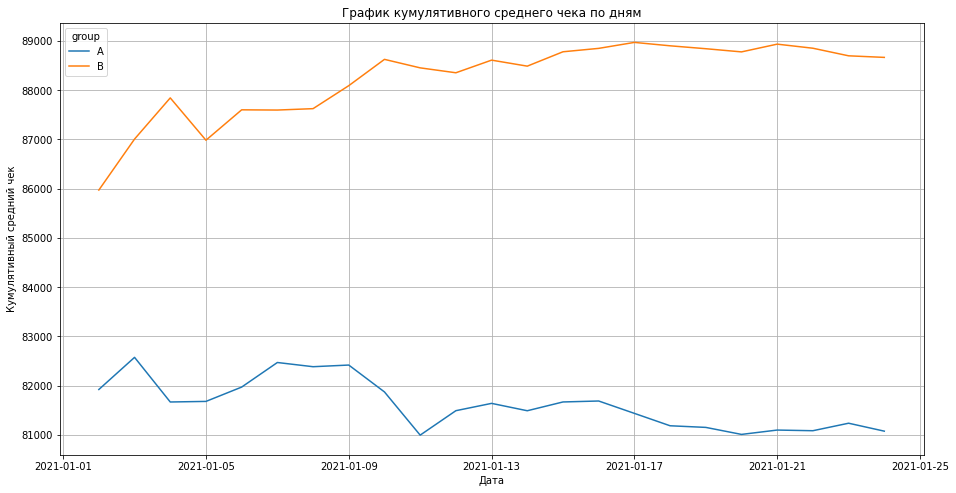

In [15]:
# строим кумулятивный график конверсии
# создаём фигуру размером 12x6
fig = plt.figure(figsize=(12, 6))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=data_info, hue='group', ax=ax)
# задаём подписи к графику
ax.set_title('График кумулятивной конверсии по дням')
ax.set_xlabel('Дата');
ax.set_ylabel('Кумулятивная конверсия')
# задаём отображение сетки
ax.grid(True);

# строим кумулятивный график среднего чека
# создаём фигуру размером 12x6
fig = plt.figure(figsize=(12, 6))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=data_info, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
ax.set_xlabel('Дата');
ax.set_ylabel('Кумулятивный средний чек')
# задаём отображение сетки
ax.grid(True);




**Выводы:**  
- Данные, запрошенные в задании, представлены в ячейке вывода (верхняя ячейка в этом задании).  
- Анализ верхнего графика показывает, что кумулятивная метрика (конверсия) стабилизировалась примерно с 11 января 2021 года. Кумулятивная конверсия после стабилизации выше в группе А. 
- Анализ нижнего графика показывает, что кумулятивная метрика (средний чек) стабилизировалась примерно также с 11 января 2021 года, причем кумулятивный средний чек **постоянно** выше в группе В.  
- В **data_info** содержатся очищенные (обновленные) первоначальные данные, сгруппированные по группам и дате (по дням) с добавленными кумуллятивными признаками.
***

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

Для решения задачи проанализируем наши данные:  
- признак группы (**group**) - категориальная независимая переменная
- признак конверсии (**conversion**) - зависимая количественная переменная
- группы происходят из разных совокупностей - А и В; пользователей, которые в первоначальных данных присутствовали в обеих группах мы удалили
- в каждой группе менее 30 объектов (**data_info** - очищенные (обновленные) первоначальные данные, сгруппированные по группам и дате (по дням) с добавленными кумуллятивными признаками) и более 30 объектов, если мы рассматриваем просто очищенные (обновленные) первоначальные данные (**updated_data**)
- у нас нет информации о разбросе данных
- конверсия (признак **conversion**)— это доля (пропорция) пользователей, которые добавили сопутствующий товар в корзину (в нашем случае купили тур)

Полагаю, что в данной ситуации правильно использовать **Z-тест для пропорций**.  
По логике задачи 7.10 и всего задания в целом, полагаю, что данные распределены нормально. Однако, также полагаю, что это нужно проверить.

Проведем **тест на нормальность Шапиро-Уилка**

In [16]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

alpha = 0.05 # уровень значимости

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(data_info[data_info['group'] == 'A']['conversion'])
shapiro_result_b = shapiro(data_info[data_info['group'] == 'B']['conversion'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.29
p-value группы B 0.91
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Проведем **тест на нормальность Д'Агостино**

In [17]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

alpha = 0.05 # уровень значимости

# вычисляем результат теста Д'Агостино
normaltest_result_a = normaltest(data_info[data_info['group'] == 'A']['conversion'])
normaltest_result_b = normaltest(data_info[data_info['group'] == 'B']['conversion'])
print('p-value группы А', round(normaltest_result_a.pvalue, 2))
print('p-value группы B', round(normaltest_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if normaltest_result_a.pvalue < alpha or normaltest_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.63
p-value группы B 0.91
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Итак, данные распределены нормально.  
Теперь нужно подготовить данные для проведения **Z-теста для пропорций**.

In [18]:
# сгруппируем дальше наши данные по признаку группы
data_info_group = data_info.groupby('group').agg({
    'count_purchases':'sum', # посчитаем общее число конверсий ("успехов")
    'count_visits':'sum' # посчитаем число посещений сайта (общее число наблюдений)
})
data_info_group

,count_purchases,count_visits
group,,
A,17487,145307
B,17290,145381


Проведем **Z-тест для пропорций**.

In [19]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'

alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=data_info_group['count_purchases'], # число "успехов"
    nobs=data_info_group['count_visits'], # общее число наблюдений
    alternative='larger' # первое значение (в группе А) больше второго (в группе В)
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**Выводы:**  
- Промежуточные выводы (задания 7.6 и 7.9) говорили о том, что конверсия в группе А более эффективна.  
- Однако проведенный статистический тест показал, что статистически значимой разницы между конверсиями в группах А и В нет.
***

## **Задание 7.11.**

Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [20]:
# используем очищенные (обновленные) первоначальные данные

# фильтруем данные группы А
updated_data_a = updated_data[updated_data['group'] == 'A']
# фильтруем данные группы B
updated_data_b = updated_data[updated_data['group'] == 'B']

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=updated_data_a['user_id'].count(), # размер выборки
x_p=updated_data_a['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data_b['user_id'].count(), # размер выборки
x_p=updated_data_b['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))



Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [21]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    '''
    данная функция рассчитывает доверительный интервал для разности конверсий
    функция принимает на вход следующие данные:
        n - размеры выборок в виде списка с двумя значениями
        xp - выборочная пропорция групп в виде списка с двумя значениями
        gamma - уровень надежности, по умолчанию равен 0.95
    функция возвращает доверительный интервал для разности конверсий в виде кортежа
    '''
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [updated_data_a['user_id'].count(), updated_data_b['user_id'].count()]
# выборочная пропорция групп A и B
xp = [updated_data_a['purchase'].mean(), updated_data_b['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

**Выводы:**
- доверительные интервалы для конверсии групп А и В перекрывают друг друга, что говорит о том, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть.  
- доверительный интервал для разности конверсий захватывает ноль - варианты А и В равнозначны по метрике конверсии.  
- мы снова убедились в том, что нет статистически значимой разницы между конверсиями в группах А и В.  
***

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

Проведем **тест на нормальность Шапиро-Уилка**.

In [22]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

alpha = 0.05 # уровень значимости

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(data_info[data_info['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(data_info[data_info['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Проведем **тест на нормальность Д'Агостино**.

In [23]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

alpha = 0.05 # уровень значимости

# вычисляем результат теста Д'Агостино
normaltest_result_a = normaltest(data_info[data_info['group'] == 'A']['mean_check'])
normaltest_result_b = normaltest(data_info[data_info['group'] == 'B']['mean_check'])
print('p-value группы А', round(normaltest_result_a.pvalue, 2))
print('p-value группы B', round(normaltest_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if normaltest_result_a.pvalue < alpha or normaltest_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.42
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


**Выводы:**  
- Для оценки нормальности распределения ежедневного среднего чека были использованы **тесты Шапиро-Уилка** и **Д'Агостино**.
- Нулевая и альтернативная гипотезы представлены в ячейках с кодом, результаты тестов представлены в ячейках вывода.  
- Согласно результатам тестов данные (ежедневный средний чек) распределены нормально.  
***

## **Задание 7.13.**

Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

Для решения задачи проанализируем наши данные:  
- признак группы (**group**) - категориальная независимая переменная
- признак ежедневного среднего чека (**mean_check**) - зависимая количественная переменная
- группы происходят из разных совокупностей - А и В; пользователей, которые в первоначальных данных присутствовали в обеих группах мы удалили
- в каждой группе менее 30 объектов (**data_info** - очищенные (обновленные) первоначальные данные, сгруппированные по группам и дате (по дням) с добавленными кумуллятивными признаками)  
- у нас нет информации о разбросе данных
- выше мы выяснили, что распределение ежедневного среднего чека нормальное в обеих группах

Полагаю, что в данной ситуации правильно использовать **Т-тест**.

In [24]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и В равны.'
Ha = 'Ежедневный средний чек в группе А меньше чем в группе В.'

alpha = 0.05 # уровень значимости

# используем data_info - очищенные (обновленные) первоначальные данные, 
# сгруппированные по группам и дате (по дням) с добавленными кумуллятивными признаками

# фильтруем данные групп А и В
data_info_a = data_info[data_info['group'] == 'A']
data_info_b = data_info[data_info['group'] == 'B']

# проводим Т-тест 
_, p = ttest_ind(data_info_a['mean_check'], 
                 data_info_b['mean_check'], 
                 alternative='less' # первое значение (группа А) меньше второго (группа В)
)

# округлим значение p-value
p = round(p, 3)

# выводим и интерпретируем результаты теста
if p>alpha:
  print(f"{p} > {alpha}.", f"Мы не можем отвергнуть нулевую гипотезу. {H0}", sep="\n")
else:
  print(f"{p} <= {alpha}.", f"Мы отвергаем нулевую гипотезу. {Ha}", sep="\n")

0.0 <= 0.05.
Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше чем в группе В.


Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

**Выводы:**  
- Ежедневный средний чек в группе А меньше, чем в группе В - разница статистически значима, что коррелирует с данными из графика кумулятивного среднего чека (задание 7.9).
- Согласно данным из того же графика, кумулятивный средний чек в группе В на всем протяжении выборки больше, чем в группе А.
- Несмотря на вышеизложенное, меня смущает полученный **p-value**, равный нулю - возможно, я допустил где-то ошибку в анализе данных.  
***

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [25]:
# данные по группам уже отфильтрованы в предыдущем задании

# расчитаем доверительный интервал для среднего чека в группе А
n = data_info_a.shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean = data_info_a['mean_check'].mean() # выборочное среднее
x_std = data_info_a['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для среднего чека в группе А: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал для среднего чека в группе А: (79630, 82308)


In [26]:
# расчитаем доверительный интервал для среднего чека в группе B
n = data_info_b.shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean = data_info_b['mean_check'].mean() # выборочное среднее
x_std = data_info_b['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для среднего чека в группе B: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал для среднего чека в группе B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

**Выводы:**  
- Доверительные интервалы не пересекаются, таким образом отсутствует вероятность того, что истинные значения среднего чека в группах могут совпасть.
- Истинное значение среднего чек в группе В выше, чем в группе А.
***

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

**Общие выводы по результатам А/В-теста:**  
- Данные были очищены от пользователей, попавшие в обе группы. Выборки сбалансированы. Данные распределены нормально.
- Конверсия покупки в группах А и В не отличаются.
- Средний чек в группе В выше, чем в группе А.
- Основной вклад в более высокий средний чек в группе В составляют туры стоимостью в 100тыс. рублей, при одновременном уменьшении купленных туров стоимостью 60тыс. рублей в той же группе (см. задание 7.7).
- Новый вариант посадочной страницы не является более эффективным по метрике конверсии, но является более эффективным по метрике среднего чека.
- В целом, новый вариант посадочной странице более эффективен, чем старый.